# 1. DATA CLEANING AND PREPERATION

### Import all needed modules

In [4]:
import numpy as np
import pandas as pd
from fredapi import Fred
import matplotlib.pyplot as plt

# yfinance modules
import yfinance as yf
import datetime
import time
import requests
import io

import statsmodels.formula.api as smf
import statsmodels.api as sm
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import cross_validate

### Functions to format our features from Fred to tables and download stock prices from yahoo finance

In [5]:
def create_table(series, column_name):
    df = series.to_frame()
    df = df.reset_index()
    df = df.rename(columns = {"index": "date", 0: column_name})
    mask = (df["date"] >= "2012-10-25") & (df["date"] <= "2022-10-21")  # datapoints between this timeframe will be downloaded
    df = df.loc[mask]
    df = df.set_index("date")  # index will be the date
    return df

In [6]:
def get_stock_price(ticker, start, end):
    stock_final = pd.DataFrame()
    stock = []
    stock = yf.download(ticker, start=start, end=end, progress=False)  # define the timeframe for the datapoints of the stockprice

    # append the individual stock prices 
    if len(stock) == 0:
        None
    else:
        stock['Name'] = ticker
        stock_final = stock_final.append(stock, sort=False)
        
    stock_final = stock_final.drop(columns = ["Open", "High", "Low", "Close", "Volume"])
    stock_final = stock_final.rename(columns = {"Adj Close": "adj_close"})
    
    return stock_final

### Import Fred data

In [7]:
# FRED ticker
# Create a dictionary which will be used later to simplify the import of the Fred data
x_factors_dict = {
    "SP500": "S&P500",
    "VIXCLS": "VIX",
    "DGS2": "_02_y_UST",
    "DGS10": "_10_y_UST",
    "T10Y2Y": "_2s10s_UST",
    "T10YIE": "_10_y_BE",
    "BAMLC0A0CM": "US_IG_OAS",
    "DEXUSEU": "EURUSD",
    "DEXJPUS": "USDJPY",
    "DEXCHUS": "USDCNH",
    "DCOILBRENTEU": "Brent_Crude",
    "DEXUSUK": "USDGBP"
            }

keys = list(x_factors_dict.keys())
values = list(x_factors_dict.values())

In [8]:
# import FRED data
fred = Fred(api_key = "4a017ca39a1f96774f9587e5956bfd6b")

# Create a variable list with the feature names in it
variable_list = []
for k, v in zip(keys, values):
    print(v)
    globals()[k] = fred.get_series(k)
    column_name_ = v
    globals()[k] = create_table(globals()[k], column_name_)
    variable_list.append(globals()[k])

S&P500
VIX
_02_y_UST
_10_y_UST
_2s10s_UST
_10_y_BE
US_IG_OAS
EURUSD
USDJPY
USDCNH
Brent_Crude
USDGBP


### Define the inputs for the upcoming functions

In [9]:
ticker = "XOM"  # enter the ticker from the stock you want to analyze (will be automatically be used as an input for all upcoming functions)
start_date = "2012-10-25"  # same as for ticker
end_date = "2022-10-21"  # same as for ticker
n = 0.7  # same as for ticker

### Import Fama French data

In [10]:
# reads an excel file where information of the features is stored (downloaded from wrds)
ff_dataframe = pd.read_excel('/Users/alexanderprinz/Desktop/Frankfurt School/Introduction to Business Analytics/Project/FamaFrench5FactorReturns.xlsx')
change_cols = ['Small-Minus-Big Return', 'High-Minus-Low Return', 'Robust Minus Weak Return', 'Conservative Minus Aggressive Return', 'Momentum']


ff_dataframe[change_cols] = (ff_dataframe[change_cols].cumsum() + 1) * 100
ff_dataframe[change_cols] = ff_dataframe[change_cols].fillna(100.0)
ff_dataframe = ff_dataframe.set_index('Date')

ff_dataframe.columns = ff_dataframe.columns.str.replace(' ', '_')
ff_dataframe.columns = ff_dataframe.columns.str.replace('-', '_')
ff_dataframe[start_date:end_date]


,Small_Minus_Big_Return,High_Minus_Low_Return,Robust_Minus_Weak_Return,Conservative_Minus_Aggressive_Return,Momentum
Date,,,,,
2012-10-25,166.10,164.40,197.53,164.44,125.24
2012-10-26,165.90,163.97,197.91,164.23,125.23
2012-10-31,166.46,164.34,197.95,164.33,125.02
2012-11-01,166.70,164.48,198.20,164.36,124.21
2012-11-02,166.23,164.72,198.51,164.82,124.25
...,...,...,...,...,...
2022-09-26,160.93,152.56,221.76,169.18,147.70
2022-09-27,161.50,151.63,221.15,168.29,147.57
2022-09-28,162.41,151.30,220.30,167.58,146.19


### Merge all features into one dataframe based on the date (Left join)

In [11]:
def create_dataset(ticker, start, end):
    # join all features together into one big dataframe
    new_dataframe = variable_list[0].join(variable_list[1:-1])
    new_dataframe = new_dataframe.join(ff_dataframe[1:-1])
    
    # join the stockprice information into the same big dataframe
    stock_final = get_stock_price(ticker, start, end)
    new_dataframe = new_dataframe.join(stock_final)
    new_dataframe = new_dataframe.drop(columns = ["Name"])
    
    
    # change to relative/ absolute change over n periods 1=abs, 0=rel
    period = 20
    change_dict = {'S&P500': 0, 
               'VIX': 1, 
               '_02_y_UST': 1, 
               '_10_y_UST': 1, 
               '_2s10s_UST': 1, 
               '_10_y_BE': 1,
               'US_IG_OAS': 1,
               'EURUSD': 0,
               'USDJPY': 0,
               'USDCNH': 0,
               'Brent_Crude': 0,
               'Small_Minus_Big_Return': 0,
               'High_Minus_Low_Return': 0,
               'Robust_Minus_Weak_Return': 0,
               'Conservative_Minus_Aggressive_Return': 0,
               'Momentum': 0,
               'adj_close': 0
              }
    
    # calc either log returns or absolute differences based on the dict above
    for key in change_dict:
        if change_dict[key] == 1:
            new_dataframe[key] = new_dataframe[key].diff(periods=period)
        else:
            new_dataframe[key] = np.log(new_dataframe[key]) - np.log(new_dataframe[key].shift(period))


    # create a new column named stock_price where you divide the adjusted close price with the S&P500 to mitigate the effect of the S&P500 on the stock price
    new_dataframe["stock_price"] = ""
    new_dataframe["stock_price"] = new_dataframe["adj_close"] - new_dataframe["S&P500"]
    # today 105 / yes 100      return: (today - yest)/yest   log(return)
    
    # drop the null values
    nan_rows  = new_dataframe[new_dataframe.isna().any(axis=1)]
    new_dataframe = new_dataframe.dropna()

    # derive the rolling z-score with a window of the last 100 datapoints
    window = 100
    rolling_dataframe = (new_dataframe.rolling(1).mean() - new_dataframe.rolling(window).mean()) / new_dataframe.rolling(window).std()
    rolling_dataframe = rolling_dataframe.dropna()
        
    return rolling_dataframe

rolling_dataframe = create_dataset(ticker, start_date, end_date)




/var/folders/26/cxj_k_hn0rg1byqs0fj1std00000gn/T/ipykernel_88715/3337518519.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  stock_final = stock_final.append(stock, sort=False)


In [12]:
%matplotlib inline

,S&P500,VIX,_02_y_UST,_10_y_UST,_2s10s_UST,_10_y_BE,US_IG_OAS,EURUSD,USDJPY,USDCNH,Brent_Crude,Small_Minus_Big_Return,High_Minus_Low_Return,Robust_Minus_Weak_Return,Conservative_Minus_Aggressive_Return,Momentum,adj_close,stock_price
S&P500,1.000000,-0.792194,0.254026,0.183212,-0.046287,0.427331,-0.601868,0.052254,0.268133,-0.157913,0.271174,0.222855,0.066789,-0.017380,-0.159837,-0.173176,0.565366,0.064387
VIX,-0.792194,1.000000,-0.214819,-0.176740,0.024310,-0.365876,0.497223,-0.000469,-0.344681,0.094377,-0.305019,-0.244146,-0.085074,0.062939,0.074480,0.191891,-0.545123,-0.158228
_02_y_UST,0.254026,-0.214819,1.000000,0.747403,0.136065,0.300186,-0.332986,-0.153572,0.437525,0.049680,0.256751,0.166196,0.313601,-0.046759,0.010161,-0.132402,0.267336,0.147259
_10_y_UST,0.183212,-0.176740,0.747403,1.000000,0.675209,0.471128,-0.409897,-0.081243,0.514194,0.007893,0.350931,0.204847,0.438403,-0.078331,0.085370,-0.174108,0.292499,0.206133
_2s10s_UST,-0.046287,0.024310,0.136065,0.675209,1.000000,0.293604,-0.184295,0.024876,0.268036,-0.001950,0.199197,0.070948,0.295542,-0.071840,0.120674,-0.096242,0.117598,0.136389
_10_y_BE,0.427331,-0.365876,0.300186,0.471128,0.293604,1.000000,-0.559970,0.045751,0.234137,-0.166841,0.496549,0.256115,0.277854,-0.098313,0.067373,-0.211455,0.418634,0.198805
US_IG_OAS,-0.601868,0.497223,-0.332986,-0.409897,-0.184295,-0.559970,1.000000,-0.070227,-0.244023,0.148900,-0.437269,-0.182589,-0.231076,0.093201,0.102448,0.281411,-0.481835,-0.173713
EURUSD,0.052254,-0.000469,-0.153572,-0.081243,0.024876,0.045751,-0.070227,1.000000,-0.394818,-0.269189,0.080707,-0.014402,-0.006458,0.047472,0.022796,-0.068816,0.030618,-0.011731
USDJPY,0.268133,-0.344681,0.437525,0.514194,0.268036,0.234137,-0.244023,-0.394818,1.000000,0.181553,0.149482,0.102144,0.206331,-0.064240,0.110579,0.014450,0.287134,0.147616
USDCNH,-0.157913,0.094377,0.049680,0.007893,-0.001950,-0.166841,0.148900,-0.269189,0.181553,1.000000,-0.174883,-0.095429,0.002731,0.085845,0.119709,0.158150,-0.079498,-0.014038


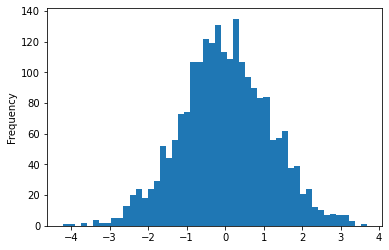

In [108]:
#rolling_dataframe["stock_price"].plot.hist(bins=50)
#rolling_dataframe.corr().style.background_gradient(cmap = "coolwarm")

### Boxplots to look for outliers

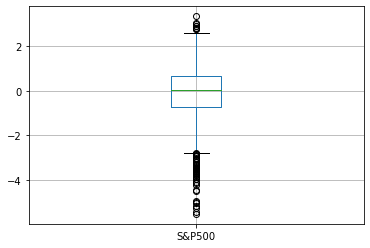

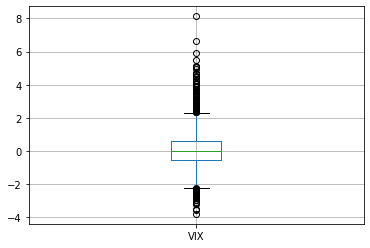

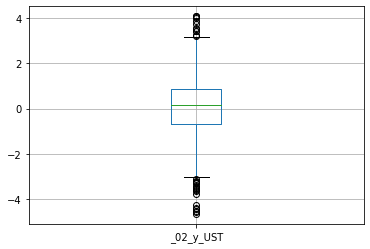

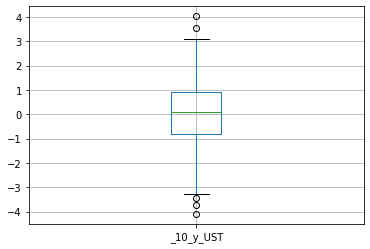

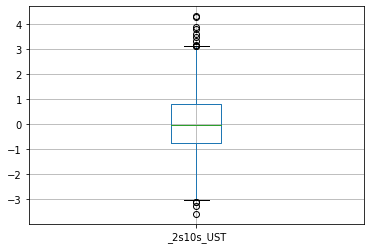

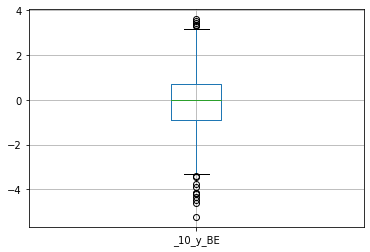

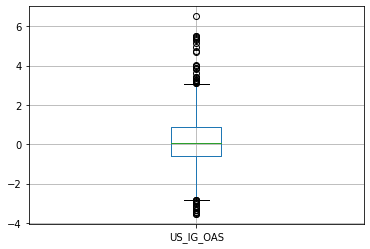

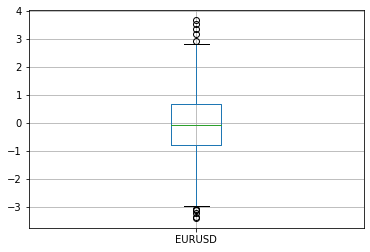

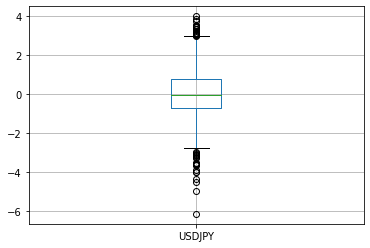

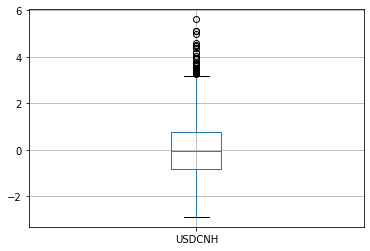

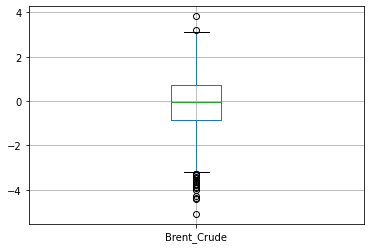

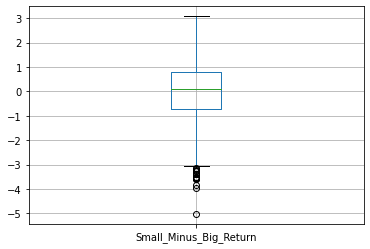

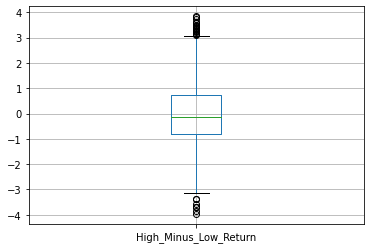

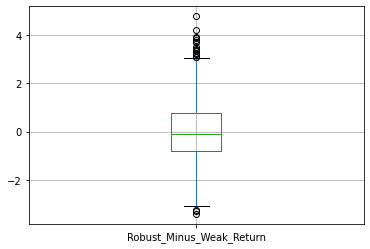

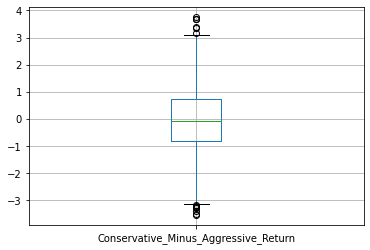

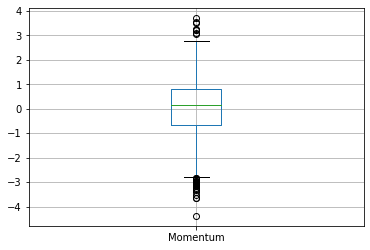

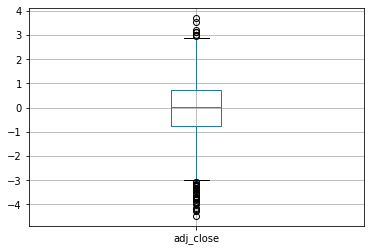

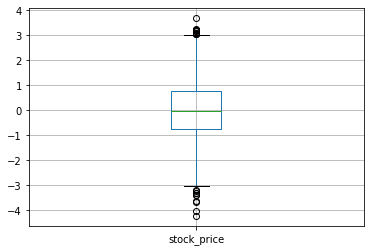

In [12]:
for c in rolling_dataframe.columns:
    rolling_dataframe.boxplot(column = [c])
    plt.show()

# 2. BASELINE MODEL

In [14]:
#X = rolling_dataframe.drop(columns = ["stock_price", "adj_close", "S&P500"])  #Feature Matrix
X = rolling_dataframe.drop(columns = ["stock_price", "adj_close"]) 
y = rolling_dataframe["stock_price"]   
X = sm.add_constant(X)

X_train = X[:'2020-01-01']
X_test = X['2020-01-01':]
y_train = y[:'2020-01-01']
y_test = y['2020-01-01':]

In [15]:
olsmodel = sm.OLS(y_train, X_train).fit()


y_predict = olsmodel.predict(X_test)
y_predict
print(f'R2: {r2_score(y_test, y_predict)}')
#print(f'Mean_Squared_error: {mean_squared_error(y_test, y_predict, squared=False)}')

# 5-Fold Cross validate model
cv_results = cross_validate(LinearRegression(), X, y, cv=5, scoring = 'r2')
# Cross validation results
#print(cv_results)
print(cv_results['test_score'].mean())
olsmodel.summary()

R2: 0.4825329306988644
0.24864256451257996


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            stock_price   R-squared:                       0.311
Model:                            OLS   Adj. R-squared:                  0.303
Method:                 Least Squares   F-statistic:                     43.74
Date:                Wed, 02 Nov 2022   Prob (F-statistic):          3.44e-113
Time:                        02:22:39   Log-Likelihood:                -2113.6
No. Observations:                1571   AIC:                             4261.
Df Residuals:                    1554   BIC:                             4352.
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
========================================================================================================
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
const                                    0.0355      0.024      1.486      0.137      -0.011       0.082
S&P500                                   0.0176      0.039      0.447      0.655      -0.060       0.095
VIX                                     -0.0129      0.036     -0.358      0.720      -0.083       0.058
_02_y_UST                                0.1978      0.059      3.352      0.001       0.082       0.313
_10_y_UST                               -0.4158      0.092     -4.498      0.000      -0.597      -0.234
_2s10s_UST                               0.1614      0.052      3.088      0.002       0.059       0.264
_10_y_BE                                -0.0569      0.030     -1.925      0.054      -0.115       0.001
US_IG_OAS                                0.0396      0.031      1.296      0.195      -0.020       0.100
EURUSD                                  -0.0708      0.025     -2.777      0.006      -0.121      -0.021
USDJPY                                   0.0804      0.028      2.825      0.005       0.025       0.136
USDCNH                                  -0.0213      0.021     -0.998      0.318      -0.063       0.021
Brent_Crude                              0.3232      0.026     12.551      0.000       0.273       0.374
Small_Minus_Big_Return                   0.0146      0.024      0.614      0.539      -0.032       0.061
High_Minus_Low_Return                    0.1251      0.030      4.163      0.000       0.066       0.184
Robust_Minus_Weak_Return                 0.0373      0.025      1.503      0.133      -0.011       0.086
Conservative_Minus_Aggressive_Return     0.2453      0.028      8.675      0.000       0.190       0.301
Momentum                                -0.1641      0.026     -6.396      0.000      -0.214      -0.114
==============================================================================
Omnibus:                        5.556   Durbin-Watson:                   0.182
Prob(Omnibus):                  0.062   Jarque-Bera (JB):                4.597
Skew:                          -0.040   Prob(JB):                        0.100
Kurtosis:                       2.747   Cond. No.                         11.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# 3. MULTIPLE LINEAR REGRESSION WITH SELECTED FEATURES

### Random forest feature selection

In [16]:
def random_forest(ticker, start, end, n):
    dataset = create_dataset(ticker, start, end)  # first create the dataset on which base the random forest will run
    
    X = dataset.drop(columns = ["stock_price", "adj_close"])
    y = dataset["stock_price"]
    
    X_train = X[:'2020-01-01']
    X_test  = X['2020-01-01':]
    y_train = y[:'2020-01-01']
    y_test  = y['2020-01-01':]
    
    
    # grid search finds the best hyper parameters.(using cross validation)
    #hyperparameter Grid
    param_grid = {
        'min_samples_split': [8, 10, 12], # Minimum number of samples required to split a node
        'n_estimators': [100, 200,300, 400, 500] # Number of trees in random forest
    }

    # Create a based model
    rf_grid = RandomForestRegressor()
    # Instantiate the grid search model
    grid_search = GridSearchCV(estimator = rf_grid, 
                               param_grid = param_grid, 
                               cv = 5, 
                               n_jobs = -1, 
                               verbose = 2)
    #fit data to Grid Search
    grid_search.fit(X_train, y_train)

    
    randomforest = grid_search.best_estimator_.fit(X_train, y_train)
    
    y_predict = randomforest.predict(X_test)
    print(f'R2 of random forest best estimator: {r2_score(y_test, y_predict)}')
    print(f'Mean_Squared_error of random forest best estimator: {mean_squared_error(y_test, y_predict, squared=False)}')
    
    features = X_train.columns
    
    f_i = list(zip(features, randomforest.feature_importances_))
    
    f_i.sort(key = lambda x : x[1])
    plt.barh([x[0] for x in f_i], [x[1] for x in f_i])
    f_i = f_i[::-1]
    
    # create a feature_list which will contain the most important features until a given threshold
    feature_list = [f_i[0]]
    counter = f_i[0][1]
    
    for i in range(1, len(f_i)):
        if f_i[i][1] + counter <= n:
            
            feature_list.append(f_i[i])
            counter += f_i[i][1]
        else:
            return feature_list
    
    return feature_list

Fitting 5 folds for each of 15 candidates, totalling 75 fits


/var/folders/26/cxj_k_hn0rg1byqs0fj1std00000gn/T/ipykernel_88676/3337518519.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  stock_final = stock_final.append(stock, sort=False)


R2 of random forest best estimator: 0.41840643331959526
Mean_Squared_error of random forest best estimator: 0.947725867948962
36.87341094017029
[('Conservative_Minus_Aggressive_Return', 0.1802524080689195), ('Brent_Crude', 0.1665285680272115), ('Momentum', 0.08577015941689954), ('US_IG_OAS', 0.058485691411483916), ('High_Minus_Low_Return', 0.057870135806796535), ('USDCNH', 0.05556115471698981), ('USDJPY', 0.049050074821835786)]


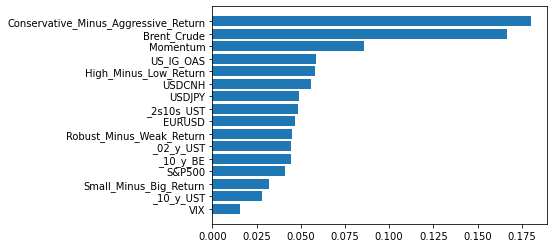

In [16]:
import time
start = time.time()
random_forest_sample = random_forest(ticker, start_date, end_date, n)
end = time.time()
total = end - start
print(total)
print(random_forest_sample)
random_forest_features = list(list(zip(*random_forest_sample))[0])

In [17]:

X_random_forest_selection = X[[c for c in X.columns if c in random_forest_features]]


In [18]:
X_random_forest_selection

,US_IG_OAS,USDJPY,USDCNH,Brent_Crude,High_Minus_Low_Return,Conservative_Minus_Aggressive_Return,Momentum
date,,,,,,,
2013-05-03,-0.802792,-0.704217,-2.062583,0.449398,-0.227726,-3.555088,-0.202947
2013-05-06,-0.789647,-1.696209,-1.531116,0.701876,0.180304,-3.415302,-0.369771
2013-05-07,-0.775638,-1.910261,-2.149911,0.565063,0.152683,-2.085717,-0.088697
2013-05-08,-0.569460,-2.223138,-2.329702,0.140245,0.310921,-2.243601,-0.368276
2013-05-09,-0.554194,-1.861909,-2.885688,0.341481,0.257063,-3.172524,-0.590079
...,...,...,...,...,...,...,...
2022-09-22,0.216521,0.444672,1.067648,-0.525874,0.446308,0.485239,1.231581
2022-09-23,0.442035,0.626084,1.247093,-1.389918,0.019920,0.255103,0.657045
2022-09-27,0.750110,0.591359,1.296408,-1.032611,-0.290371,-0.139287,0.832928


### Multiple linear regression with the selected features of the random forest

In [19]:
X_ = X_random_forest_selection
X_ = sm.add_constant(X_)
y_ = rolling_dataframe["stock_price"]


X_train_ = X_[:'2020-01-01']
X_test_ = X_['2020-01-01':]
y_train_ = y_[:'2020-01-01']
y_test_ = y_['2020-01-01':]

ols_selected_features = sm.OLS(y_train_, X_train_).fit()
ols_selected_features.summary()

y_predict_ = ols_selected_features.predict(X_test_)
y_predict_
print(f'R2: {r2_score(y_test_, y_predict_)}')
#print(f'Mean_Squared_error: {mean_squared_error(y_test_, y_predict_, squared=False)}')


# 5-Fold Cross validate model
cv_results = cross_validate(LinearRegression(), X_, y_, cv=5, scoring = 'r2')
# Cross validation results
#print(cv_results)
print(cv_results['test_score'].mean())
ols_selected_features.summary()

R2: 0.5584692177604398
0.30492507345063596


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            stock_price   R-squared:                       0.285
Model:                            OLS   Adj. R-squared:                  0.281
Method:                 Least Squares   F-statistic:                     88.79
Date:                Wed, 02 Nov 2022   Prob (F-statistic):          5.22e-109
Time:                        02:19:15   Log-Likelihood:                -2142.7
No. Observations:                1571   AIC:                             4301.
Df Residuals:                    1563   BIC:                             4344.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
========================================================================================================
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
const                                    0.0373      0.024      1.547      0.122      -0.010       0.085
US_IG_OAS                                0.0875      0.024      3.694      0.000       0.041       0.134
USDJPY                                   0.0692      0.022      3.077      0.002       0.025       0.113
USDCNH                                   0.0061      0.020      0.296      0.767      -0.034       0.046
Brent_Crude                              0.2854      0.025     11.611      0.000       0.237       0.334
High_Minus_Low_Return                    0.0810      0.028      2.891      0.004       0.026       0.136
Conservative_Minus_Aggressive_Return     0.2587      0.027      9.683      0.000       0.206       0.311
Momentum                                -0.1813      0.025     -7.338      0.000      -0.230      -0.133
==============================================================================
Omnibus:                        2.040   Durbin-Watson:                   0.165
Prob(Omnibus):                  0.361   Jarque-Bera (JB):                2.058
Skew:                          -0.060   Prob(JB):                        0.357
Kurtosis:                       2.870   Cond. No.                         2.49
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Plot the regression

In [ ]:
def partial_regression_plots(random_forest_regression):
    fig = plt.figure(figsize = (8, 15))  # adjust the size of the figures
    fig = sm.graphics.plot_partregress_grid(random_forest_regression, fig = fig)
    return fig

regression_plots = partial_regression_plots(ols_selected_features)

### check multicoliniarity

In [ ]:
X_random_forest_selection.corr().style.background_gradient(cmap = "coolwarm")

## MODEL EVALUATION

test data import: Dow Jones Industrials Constituents

In [47]:
df = pd.read_csv("/Users/alexanderprinz/Downloads/djia_const_tr.csv")

In [48]:
df['DlyCalDt'] = df['DlyCalDt'].apply(lambda x: pd.to_datetime(str(x), format='%Y%m%d'))
df = df.pivot_table(index='DlyCalDt', columns='IssuerNm', values='DlyRet', fill_value=0)
header_list = df.keys()
df[header_list] = (df[header_list].cumsum() + 1) * 100
df = df.drop(columns = ["DOW CHEMICAL CO", "DOW INC"]) # incomplete data

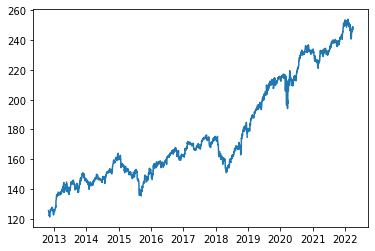

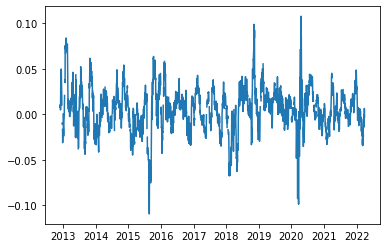

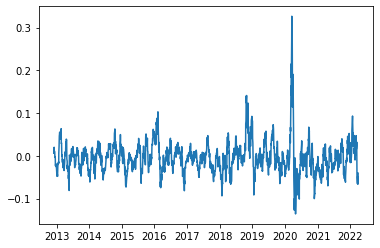

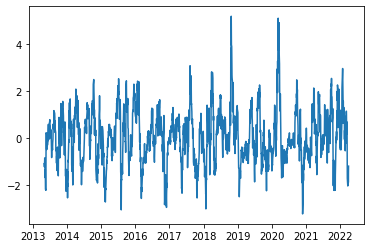

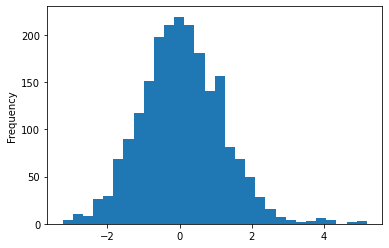

AttributeError: 'AxesSubplot' object has no attribute 'show'

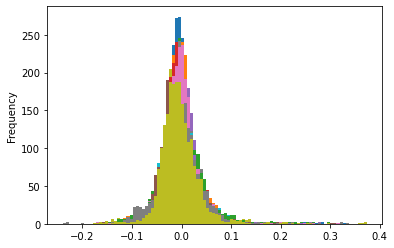

In [102]:
# join all features together into one big dataframe
evaluation_dataframe = variable_list[0].join(variable_list[1:-1])
evaluation_dataframe = evaluation_dataframe.join(ff_dataframe[1:-1])
evaluation_dataframe = evaluation_dataframe.join(df)
'''plt.plot(evaluation_dataframe["PROCTER & GAMBLE CO"])
plt.savefig('PG_abs.png')
plt.show()'''
# change to relative/ absolute change over n periods 1=abs, 0=rel
period = 20
change_dict = {'S&P500': 0, 
           'VIX': 1, 
           '_02_y_UST': 1, 
           '_10_y_UST': 1, 
           '_2s10s_UST': 1, 
           '_10_y_BE': 1,
           'US_IG_OAS': 1,
           'EURUSD': 0,
           'USDJPY': 0,
           'USDCNH': 0,
           'Brent_Crude': 0,
           'Small_Minus_Big_Return': 0,
           'High_Minus_Low_Return': 0,
           'Robust_Minus_Weak_Return': 0,
           'Conservative_Minus_Aggressive_Return': 0,
           'Momentum': 0
          }


# calc either log returns or absolute differences based on the dict above
for key in list(evaluation_dataframe):
    if key not in change_dict:
        change_dict[key] = 0
        evaluation_dataframe[key] = np.log(evaluation_dataframe[key]) - np.log(evaluation_dataframe[key].shift(period))
    elif change_dict[key] == 1:
        evaluation_dataframe[key] = evaluation_dataframe[key].diff(periods=period)
    else:
        evaluation_dataframe[key] = np.log(evaluation_dataframe[key]) - np.log(evaluation_dataframe[key].shift(period))

'''plt.plot(evaluation_dataframe["PROCTER & GAMBLE CO"])
plt.savefig('PG_logret.png')
plt.show()'''
for stock in list(evaluation_dataframe.iloc[:,16:]):
    evaluation_dataframe[stock] = evaluation_dataframe[stock] - evaluation_dataframe["S&P500"]


# drop the null values
evaluation_dataframe = evaluation_dataframe.dropna() 
'''plt.plot(evaluation_dataframe["PROCTER & GAMBLE CO"])
plt.savefig('PG_rel.png')
plt.show()'''

# derive the rolling z-score with a window of the last 100 datapoints
window = 100
rolling_evaluation_dataframe = (evaluation_dataframe.rolling(1).mean() - evaluation_dataframe.rolling(window).mean()) / evaluation_dataframe.rolling(window).std()
rolling_evaluation_dataframe = rolling_evaluation_dataframe.dropna() 
'''plt.plot(rolling_evaluation_dataframe["PROCTER & GAMBLE CO"])
plt.savefig('PG_standardized.png')
plt.show()'''


'''rolling_evaluation_dataframe["PROCTER & GAMBLE CO"].plot.hist(bins=30)
plt.savefig('PG_standardized_hist.png')
plt.show()

ax = evaluation_dataframe.iloc[:,16:].plot.hist(bins=100)
ax.get_legend().remove()
plt.savefig('all_stocks_hist.png')
ax.show()'''

In [50]:
### Inputs for the evaluation
test_features = rolling_evaluation_dataframe.iloc[:,0:16]
test_stocks = rolling_evaluation_dataframe.iloc[:,16:]


In [51]:
def get_rsq(X,y):                      
    X = sm.add_constant(X)

    X_train = X[:'2020-01-01']
    X_test = X['2020-01-01':]
    y_train = y[:'2020-01-01']
    y_test = y['2020-01-01':]
    
    olsmodel = sm.OLS(y_train, X_train).fit()

    y_predict = olsmodel.predict(X_test)

    # 5-Fold Cross validate model
    cv_results = cross_validate(LinearRegression(), X, y, cv=5, scoring = 'r2')
    return cv_results['test_score'].mean()

In [52]:
def random_forest_evaluation(X, y, n):

    X_train = X[:'2020-01-01']
    X_test  = X['2020-01-01':]
    y_train = y[:'2020-01-01']
    y_test  = y['2020-01-01':]
    
    
    # grid search finds the best hyper parameters.(using cross validation)
    #hyperparameter Grid
    param_grid = {
        'min_samples_split': [8, 10, 12], # Minimum number of samples required to split a node
        'n_estimators': [100, 200,300, 400, 500] # Number of trees in random forest
    }

    # Create a based model
    rf_grid = RandomForestRegressor()
    # Instantiate the grid search model
    grid_search = GridSearchCV(estimator = rf_grid, 
                               param_grid = param_grid, 
                               cv = 5, 
                               n_jobs = -1, 
                               verbose = 2)
    #fit data to Grid Search
    grid_search.fit(X_train, y_train)

    
    randomforest = grid_search.best_estimator_.fit(X_train, y_train) 
    
    y_predict = randomforest.predict(X_test)
    
    features = X_train.columns
    
    f_i = list(zip(features, randomforest.feature_importances_))
    
    f_i.sort(key = lambda x : x[1])
    plt.barh([x[0] for x in f_i], [x[1] for x in f_i])
    f_i = f_i[::-1]
    
    # create a feature_list which will contain the most important features until a given threshold
    feature_list = [f_i[0]]
    counter = f_i[0][1]
    
    for i in range(1, len(f_i)):
        if f_i[i][1] + counter <= n:
            
            feature_list.append(f_i[i])
            counter += f_i[i][1]
        else:
            return feature_list
    
    return feature_list

Fitting 5 folds for each of 15 candidates, totalling 75 fits
['S&P500', 'Conservative_Minus_Aggressive_Return', 'USDCNH', 'Small_Minus_Big_Return', 'Brent_Crude', 'US_IG_OAS']


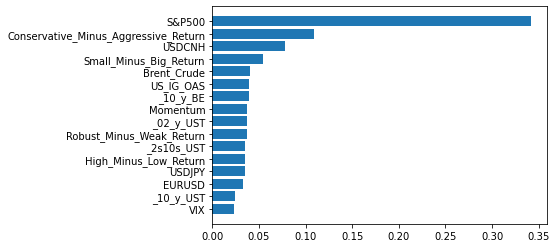

In [60]:
feature_list_evaluation = random_forest_evaluation(test_features, test_stocks["TESLA INC"], 0.7)
random_forest_features = list(list(zip(*feature_list_evaluation))[0])
print(random_forest_features)


0.3424894410421338


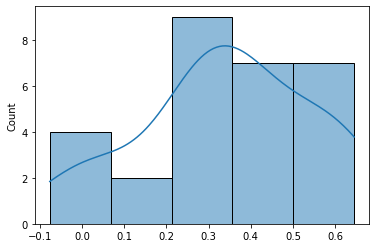

In [78]:
### baseline model results
rsquareds = []
nmbr_of_features = []
i = 0
while i < len(test_stocks.keys()):
    rsquareds.append(get_rsq(test_features, test_stocks.iloc[:,i:i+1]))
    i += 1
    
    
'''base_r2_hist = sns.histplot(data=rsquareds, bins=5, kde=True)
fig = base_r2_hist.get_figure()
fig.savefig("Baseline_R2_Hist.png")'''

 
print(mean(rsquareds))

Fitting 5 folds for each of 15 candidates, totalling 75 fits
Fitting 5 folds for each of 15 candidates, totalling 75 fits
Fitting 5 folds for each of 15 candidates, totalling 75 fits
Fitting 5 folds for each of 15 candidates, totalling 75 fits
Fitting 5 folds for each of 15 candidates, totalling 75 fits
Fitting 5 folds for each of 15 candidates, totalling 75 fits
Fitting 5 folds for each of 15 candidates, totalling 75 fits
Fitting 5 folds for each of 15 candidates, totalling 75 fits
Fitting 5 folds for each of 15 candidates, totalling 75 fits
Fitting 5 folds for each of 15 candidates, totalling 75 fits
Fitting 5 folds for each of 15 candidates, totalling 75 fits
Fitting 5 folds for each of 15 candidates, totalling 75 fits
Fitting 5 folds for each of 15 candidates, totalling 75 fits
Fitting 5 folds for each of 15 candidates, totalling 75 fits
Fitting 5 folds for each of 15 candidates, totalling 75 fits
Fitting 5 folds for each of 15 candidates, totalling 75 fits
Fitting 5 folds for each

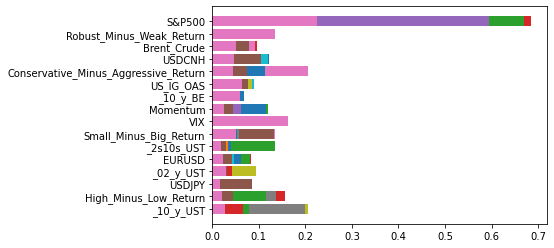

[CV] END .............min_samples_split=12, n_estimators=400; total time=   4.8s
[CV] END ..............min_samples_split=8, n_estimators=200; total time=   2.6s
[CV] END ..............min_samples_split=8, n_estimators=400; total time=   5.4s
[CV] END ..............min_samples_split=8, n_estimators=500; total time=   7.1s
[CV] END .............min_samples_split=10, n_estimators=300; total time=   4.1s
[CV] END .............min_samples_split=10, n_estimators=500; total time=   6.5s
[CV] END .............min_samples_split=12, n_estimators=300; total time=   4.0s
[CV] END .............min_samples_split=12, n_estimators=400; total time=   5.3s
[CV] END ..............min_samples_split=8, n_estimators=100; total time=   1.3s
[CV] END ..............min_samples_split=8, n_estimators=300; total time=   3.9s
[CV] END ..............min_samples_split=8, n_estimators=400; total time=   5.3s
[CV] END .............min_samples_split=10, n_estimators=100; total time=   1.3s
[CV] END .............min_sa

In [103]:
### RF model results  - takes a long time to calculate! approx 3*30*45sec on m1 silicon
rsquareds_RF_50 = []
nmbr_of_features_RF_50 = []

rsquareds_RF_70 = []
nmbr_of_features_RF_70 = []

rsquareds_RF_90 = []
nmbr_of_features_RF_90 = []

length = (len(test_stocks.keys()))
i = 0
n = 0.5 # (threshold random forest feature selection)
while i < length:
    feature_list_evaluation = random_forest_evaluation(test_features, np.squeeze(test_stocks.iloc[:,i:i+1]), n)
    nmbr_of_features_RF_50.append(len(feature_list_evaluation))
    RF_test_features = test_features[list(list(zip(*feature_list_evaluation))[0])]
    rsquareds_RF_50.append(get_rsq(RF_test_features, test_stocks.iloc[:,i:i+1]))
    i += 1

i = 0
n = 0.7 # (threshold random forest feature selection)
while i < length:
    feature_list_evaluation = random_forest_evaluation(test_features, np.squeeze(test_stocks.iloc[:,i:i+1]), n)
    nmbr_of_features_RF_70.append(len(feature_list_evaluation))
    RF_test_features = test_features[list(list(zip(*feature_list_evaluation))[0])]
    rsquareds_RF_70.append(get_rsq(RF_test_features, test_stocks.iloc[:,i:i+1]))
    i += 1
    
i = 0
n = 0.9 # (threshold random forest feature selection)
while i < length:
    feature_list_evaluation = random_forest_evaluation(test_features, np.squeeze(test_stocks.iloc[:,i:i+1]), n)
    nmbr_of_features_RF_90.append(len(feature_list_evaluation))
    RF_test_features = test_features[list(list(zip(*feature_list_evaluation))[0])]
    rsquareds_RF_90.append(get_rsq(RF_test_features, test_stocks.iloc[:,i:i+1]))
    i += 1

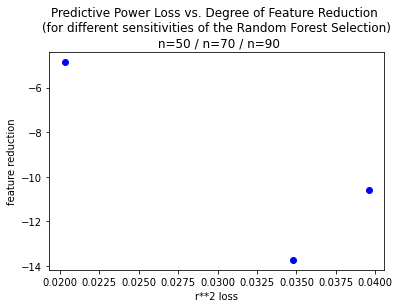

In [46]:
from statistics import mean

#baseline result lists
rsquareds
nmbr_of_features

#RF result lists
rsquareds_RF_50
nmbr_of_features_RF_50
rsq_50_loss = [r1 - r2 for (r1, r2) in zip(rsquareds_RF_50, rsquareds)]
ft_red_50 = [nf - 16 for nf in nmbr_of_features_RF_50]

rsquareds_RF_70
nmbr_of_features_RF_70
rsq_70_loss = [r1 - r2 for (r1, r2) in zip(rsquareds_RF_70, rsquareds)]
ft_red_70 = [nf - 16 for nf in nmbr_of_features_RF_70]

rsquareds_RF_90
nmbr_of_features_RF_90
rsq_90_loss = [r1 - r2 for (r1, r2) in zip(rsquareds_RF_90, rsquareds)]
ft_red_90 = [nf - 16 for nf in nmbr_of_features_RF_90]

mean_rsq_loss = [mean(rsq_50_loss),mean(rsq_70_loss),mean(rsq_90_loss)]
mean_ft_red = [mean(ft_red_50),mean(ft_red_70),mean(ft_red_90)]

plt.scatter(mean_rsq_loss, mean_ft_red, c ="blue")
plt.ylabel("feature reduction")
plt.xlabel("r**2 loss")
plt.title("Predictive Power Loss vs. Degree of Feature Reduction \n(for different sensitivities of the Random Forest Selection)\n n=50 / n=70 / n=90")
plt.show()


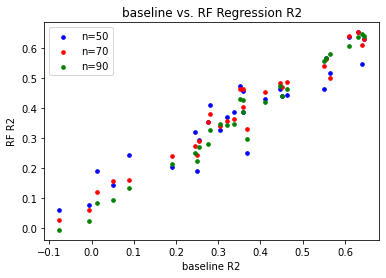

In [75]:
# Scatterplot - r2 comparison
x = rsquareds
y1 = rsquareds_RF_50
y2 = rsquareds_RF_70
y3 = rsquareds_RF_90

# Plot
plt.scatter(x,y1,color = 'blue', label = "n=50", s=13)
plt.scatter(x,y2,color = 'red', label = "n=70", s=13)
plt.scatter(x,y3,color = 'green', label = "n=90", s=13)
#plt.rcParams.update({'figure.figsize':(5,5), 'figure.dpi':300})

# Decorate
plt.title("baseline vs. RF Regression R2")
plt.xlabel('baseline R2')
plt.ylabel('RF R2')
plt.legend(loc='best')
plt.savefig('Baseline_vs_RF_R2.png')
plt.show()

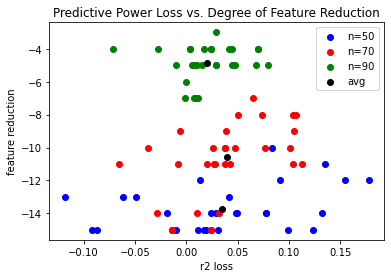

<AxesSubplot:xlabel='rsq_loss', ylabel='feat_reduction'>

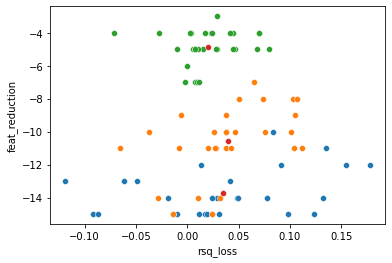

In [76]:
# Scatterplot - predictive power vs. feature reduction
x1 = rsq_50_loss
x2 = rsq_70_loss
x3 = rsq_90_loss
x4 = mean_rsq_loss

y1 = ft_red_50
y2 = ft_red_70
y3 = ft_red_90
y4 = mean_ft_red

# Plot
plt.scatter(x1,y1,color = 'blue', label = "n=50")
plt.scatter(x2,y2,color = 'red', label = "n=70")
plt.scatter(x3,y3,color = 'green', label = "n=90")
plt.scatter(x4,y4,color = 'black', label = "avg", )
#plt.rcParams.update({'figure.figsize':(5,5), 'figure.dpi':300})

# Decorate
plt.title("Predictive Power Loss vs. Degree of Feature Reduction")
plt.xlabel('r2 loss')
plt.ylabel('feature reduction')
plt.legend(loc='best')
plt.savefig('feat_red_vs_R2_loss.png')
plt.show()

